### Extract data


In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

# Path to the input XML file
input_file = "data/kanjivg-20240807.xml"

# Parse the XML file
tree = ET.parse(input_file)
root = tree.getroot()

namespaces = {"kvg": "http://kanjivg.tagaini.net"}

# List to store data
data = []

def extract_paths(kanji_id, element, g_element):
    """Recursively extract paths and data from <g> elements."""
    for path in g_element.findall("path", namespaces):
        path_id = path.attrib.get("id", "")
        path_type = path.attrib.get("{http://kanjivg.tagaini.net}type", "")
        path_d = path.attrib.get("d", "")
        
        # Append data to the list
        data.append({
            "kanji_id": kanji_id,
            "element": element,
            "path_id": path_id,
            "type": path_type,
            "svg_path": path_d
        })
    
    # Recursively process nested <g> elements
    for nested_g in g_element.findall("g", namespaces):
        extract_paths(kanji_id, element, nested_g)

# Iterate through each <kanji> element
for kanji in root.findall("kanji"):
    kanji_id = kanji.get("id", "")  # Extract kanji ID
    
    # Find the first <g> element under the <kanji>
    first_g = kanji.find("g", namespaces)
    if first_g is not None:
        element = first_g.attrib.get("{http://kanjivg.tagaini.net}element", "")
        
        # Extract paths recursively
        extract_paths(kanji_id, element, first_g)

# Convert the list of dictionaries into a Pandas DataFrame
df1 = pd.DataFrame(data)

# Display the first few rows
print(df1["kanji_id"].unique().size)
df1.head()


6699


,kanji_id,element,path_id,type,svg_path
0,kvg:kanji_00021,!,kvg:00021-s1,,"M54.5,15.79c0,6.07-0.29,55.49-0.29,60.55"
1,kvg:kanji_00021,!,kvg:00021-s2,,"M54.5,88 c -0.83,0 -1.5,0.67 -1.5,1.5 0,0.83 0..."
2,kvg:kanji_0002c,",",kvg:0002c-s1,,"M14,103.36c3.61-2.46,6.65-6.21,6.65-13.29c0-1...."
3,kvg:kanji_0002e,.,kvg:0002e-s1,,"M15,88 c -1.66,0 -3,1.34 -3,3 0,1.66 1.34,3 3,..."
4,kvg:kanji_00030,0,kvg:00030-s1,,"M54.89,15.5c-10.26,0-27.89,8.82-27.89,38.15c0,..."


In [3]:
# Save to svg file

import os
import xml.etree.ElementTree as ET

# Path to the XML file and output directory
xml_file = "data/kanjivg-20240807.xml"  # Path to your KanjiVG file
output_dir = "data/kanji_svgs"  # Output directory for SVGs

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define SVG namespace
svg_namespace = "http://www.w3.org/2000/svg"
xlink_namespace = "http://www.w3.org/1999/xlink"

# Register namespaces
ET.register_namespace("", svg_namespace)
ET.register_namespace("xlink", xlink_namespace)

# Parse the XML file
tree = ET.parse(xml_file)
root = tree.getroot()

# Iterate through all <kanji> elements
for kanji in root.findall("kanji"):
    kanji_id = kanji.attrib['id']  # Get the kanji Unicode ID
    svg_content = [
        f'<svg xmlns="{svg_namespace}" xmlns:xlink="{xlink_namespace}" viewBox="0 0 109 109">',
        '<style>',
        'path { fill: none; stroke: black; stroke-width: 3; stroke-linecap: round; stroke-linejoin: round; }',
        '</style>'
    ]

    # Append all child elements (<g>, <path>, etc.) with full attributes
    for element in kanji:
        svg_content.append(ET.tostring(element, encoding='unicode'))

    svg_content.append("</svg>")

    # Write the SVG to an output file
    output_path = os.path.join(output_dir, f"{kanji_id}.svg")
    with open(output_path, "w", encoding="utf-8") as svg_file:
        svg_file.write("\n".join(svg_content))

print(f"SVG files saved in {output_dir}")


SVG files saved in data/kanji_svgs


In [4]:
# Path to the input XML file
input_file = "data/kanjidic2.xml"

# Parse the XML file
tree = ET.parse(input_file)
root = tree.getroot()

# List to store extracted data
kanji_data = []

# Iterate through each <character> element
for character in root.findall("character"):
    # Extract basic information
    literal = character.findtext("literal", default="")
    ucs = character.find("codepoint/cp_value[@cp_type='ucs']").text if character.find("codepoint/cp_value[@cp_type='ucs']") else ""
    jis208 = character.find("codepoint/cp_value[@cp_type='jis208']").text if character.find("codepoint/cp_value[@cp_type='jis208']") else ""
    grade = character.find("misc/grade").text if character.find("misc/grade") else ""
    stroke_count = character.find("misc/stroke_count").text if character.find("misc/stroke_count") else ""
    freq = character.find("misc/freq").text if character.find("misc/freq") else ""
    jlpt = character.find("misc/jlpt").text if character.find("misc/jlpt") else ""
    
    # Extract meanings
    meanings = [meaning.text for meaning in character.findall("reading_meaning/rmgroup/meaning") if not meaning.attrib]
    
    # Extract readings
    readings_on = [reading.text for reading in character.findall("reading_meaning/rmgroup/reading[@r_type='ja_on']")]
    readings_kun = [reading.text for reading in character.findall("reading_meaning/rmgroup/reading[@r_type='ja_kun']")]
    
    # Store the data in a dictionary
    kanji_info = {
        "literal": literal,
        "ucs": ucs,
        "jis208": jis208,
        "grade": grade,
        "stroke_count": stroke_count,
        "frequency": freq,
        "jlpt": jlpt,
        "meanings": ", ".join(meanings),
        "readings_on": ", ".join(readings_on),
        "readings_kun": ", ".join(readings_kun),
    }
    kanji_data.append(kanji_info)

# Convert the list of dictionaries to a Pandas DataFrame
df2 = pd.DataFrame(kanji_data)

df2.head(20)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13108 entries, 0 to 13107
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   literal       13108 non-null  object
 1   ucs           13108 non-null  object
 2   jis208        13108 non-null  object
 3   grade         13108 non-null  object
 4   stroke_count  13108 non-null  object
 5   frequency     13108 non-null  object
 6   jlpt          13108 non-null  object
 7   meanings      13108 non-null  object
 8   readings_on   13108 non-null  object
 9   readings_kun  13108 non-null  object
dtypes: object(10)
memory usage: 1.0+ MB


In [5]:
df1 = df1[["kanji_id", "element"]]
df1_cleaned = df1.drop_duplicates()
df1_cleaned = df1_cleaned.rename(columns={"element":"literal"})

df = pd.merge(df1_cleaned, df2, how="inner", on="literal")
df[["kanji_id", "literal", "meanings"]]

,kanji_id,literal,meanings
0,kvg:kanji_0342c,㐬,"a cup with pendants, a pennant, wild, barren, ..."
1,kvg:kanji_034c1,㓁,"a net, net-like, radical 122"
2,kvg:kanji_04e00,一,"one, one radical (no.1)"
3,kvg:kanji_04e01,丁,"street, ward, town, counter for guns, tools, l..."
4,kvg:kanji_04e03,七,seven
...,...,...,...
6408,kvg:kanji_09fa0,龠,flute
6409,kvg:kanji_200a4,𠂤,"to store up, to pile up"
6410,kvg:kanji_201a2,𠆢,
6411,kvg:kanji_20b9f,𠮟,"scold, reprove"


In [6]:
# Convert svg into png
import os
import subprocess

# Input and output directories
input_dir = "data/kanji_svgs"  # Directory containing SVG files
output_dir = "data/kanji_pngs"  # Directory for converted images
os.makedirs(output_dir, exist_ok=True)

# Batch conversion using rsvg-convert
for svg_file in os.listdir(input_dir):
    if svg_file.endswith(".svg"):
        input_path = os.path.join(input_dir, svg_file)
        output_path = os.path.join(output_dir, os.path.splitext(svg_file)[0] + ".png")
        
        # Run rsvg-convert command
        subprocess.run(["rsvg-convert", "-w", "128", "-h", "128", input_path, "-o", output_path])
        print(f"Converted: {svg_file} -> {output_path}")

Converted: kvg:kanji_082e3.svg -> data/kanji_pngs/kvg:kanji_082e3.png
Converted: kvg:kanji_07a83.svg -> data/kanji_pngs/kvg:kanji_07a83.png
Converted: kvg:kanji_062dd.svg -> data/kanji_pngs/kvg:kanji_062dd.png
Converted: kvg:kanji_09670.svg -> data/kanji_pngs/kvg:kanji_09670.png
Converted: kvg:kanji_0571f.svg -> data/kanji_pngs/kvg:kanji_0571f.png
Converted: kvg:kanji_096aa.svg -> data/kanji_pngs/kvg:kanji_096aa.png
Converted: kvg:kanji_08208.svg -> data/kanji_pngs/kvg:kanji_08208.png
Converted: kvg:kanji_09102.svg -> data/kanji_pngs/kvg:kanji_09102.png
Converted: kvg:kanji_065cf.svg -> data/kanji_pngs/kvg:kanji_065cf.png
Converted: kvg:kanji_05738.svg -> data/kanji_pngs/kvg:kanji_05738.png
Converted: kvg:kanji_0570b.svg -> data/kanji_pngs/kvg:kanji_0570b.png
Converted: kvg:kanji_0767c.svg -> data/kanji_pngs/kvg:kanji_0767c.png
Converted: kvg:kanji_082d7.svg -> data/kanji_pngs/kvg:kanji_082d7.png
Converted: kvg:kanji_07a97.svg -> data/kanji_pngs/kvg:kanji_07a97.png
Converted: kvg:kanji

In [26]:
# Convert into mono scale
from PIL import Image
import os

# Define the input and output directory
input_dir = "data/kanji_pngs"
output_dir = "data/dataset"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each file in the directory
for filename in os.listdir(input_dir):
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # Open image and convert to grayscale
    img = Image.open(input_path) # Preserve transparency
    white_bg = Image.new("RGBA", img.size, (255, 255, 255, 255))  # Create white background
    img = Image.alpha_composite(white_bg, img) #.convert("L")

    # Save the grayscale image
    img.save(output_path)
    print(f"Converted: {filename}")

print("All images converted to grayscale successfully.")


Converted: kvg:kanji_05b9a.png
Converted: kvg:kanji_052d8.png
Converted: kvg:kanji_0937e.png
Converted: kvg:kanji_067d1.png
Converted: kvg:kanji_087ef.png
Converted: kvg:kanji_07d8f.png
Converted: kvg:kanji_08737.png
Converted: kvg:kanji_2008a.png
Converted: kvg:kanji_05207.png
Converted: kvg:kanji_0673d.png
Converted: kvg:kanji_06068.png
Converted: kvg:kanji_07d9b.png
Converted: kvg:kanji_052ff.png
Converted: kvg:kanji_087e0.png
Converted: kvg:kanji_05b97.png
Converted: kvg:kanji_0557c.png
Converted: kvg:kanji_080c6.png
Converted: kvg:kanji_06726.png
Converted: kvg:kanji_080b2.png
Converted: kvg:kanji_0520a.png
Converted: kvg:kanji_05b83.png
Converted: kvg:kanji_067ec.png
Converted: kvg:kanji_08079.png
Converted: kvg:kanji_07d4e.png
Converted: kvg:kanji_07cd2.png
Converted: kvg:kanji_05b5b.png
Converted: kvg:kanji_04f10.png
Converted: kvg:kanji_05bc3.png
Converted: kvg:kanji_05e3d.png
Converted: kvg:kanji_07db4.png
Converted: kvg:kanji_06901.png
Converted: kvg:kanji_08938.png
Converte

In [ ]:
img = Image.open(output_path)

In [9]:
# Rename
df["file_name"] = df["kanji_id"] + ".png"
df = df.rename(columns={"meanings":"text"})

# Check if each file exists
df["file_exists"] = df["file_name"].apply(lambda x: os.path.exists("data/dataset/"+x))
df = df[df.file_exists][["file_name", "text"]]
df.head()

,file_name,text
0,kvg:kanji_0342c.png,"a cup with pendants, a pennant, wild, barren, ..."
1,kvg:kanji_034c1.png,"a net, net-like, radical 122"
2,kvg:kanji_04e00.png,"one, one radical (no.1)"
3,kvg:kanji_04e01.png,"street, ward, town, counter for guns, tools, l..."
4,kvg:kanji_04e03.png,seven


In [11]:
# Export to a JSONL file
output_file = "data/dataset/metadata.jsonl"
df.to_json(output_file, orient="records", lines=True)

print(f"DataFrame exported to {output_file}")

DataFrame exported to data/dataset/metadata.jsonl


In [14]:
# Read the JSONL file back into a DataFrame
!head -n 10 data/dataset/metadata.jsonl

{"file_name":"kvg:kanji_0342c.png","text":"a cup with pendants, a pennant, wild, barren, uncultivated"}
{"file_name":"kvg:kanji_034c1.png","text":"a net, net-like, radical 122"}
{"file_name":"kvg:kanji_04e00.png","text":"one, one radical (no.1)"}
{"file_name":"kvg:kanji_04e01.png","text":"street, ward, town, counter for guns, tools, leaves or cakes of something, even number, 4th calendar sign"}
{"file_name":"kvg:kanji_04e03.png","text":"seven"}
{"file_name":"kvg:kanji_04e07.png","text":"ten thousand, 10,000"}
{"file_name":"kvg:kanji_04e08.png","text":"length, ten shaku, measure, Mr., Ms., height, stature, all (one has), only, that's all, merely"}
{"file_name":"kvg:kanji_04e09.png","text":"three"}
{"file_name":"kvg:kanji_04e0a.png","text":"above, up"}
{"file_name":"kvg:kanji_04e0b.png","text":"below, down, descend, give, low, inferior"}


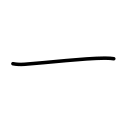

In [27]:
from IPython.display import Image, display

# Path to your PNG file
file_name = "kvg:kanji_04e00.png"
png_file_path = "data/dataset/" + file_name

# Display the image
display(Image(filename=png_file_path))


In [28]:
!zip -r dataset.zip data/dataset/

  adding: data/dataset/ (stored 0%)
  adding: data/dataset/kvg:kanji_05b9a.png (deflated 1%)
  adding: data/dataset/kvg:kanji_052d8.png (deflated 1%)
  adding: data/dataset/kvg:kanji_0937e.png (deflated 2%)
  adding: data/dataset/kvg:kanji_067d1.png (deflated 1%)
  adding: data/dataset/kvg:kanji_087ef.png (deflated 1%)
  adding: data/dataset/kvg:kanji_07d8f.png (deflated 0%)
  adding: data/dataset/kvg:kanji_08737.png (deflated 1%)
  adding: data/dataset/kvg:kanji_2008a.png (stored 0%)
  adding: data/dataset/kvg:kanji_05207.png (deflated 2%)
  adding: data/dataset/kvg:kanji_0673d.png (deflated 1%)
  adding: data/dataset/kvg:kanji_06068.png (deflated 1%)
  adding: data/dataset/kvg:kanji_07d9b.png (deflated 1%)
  adding: data/dataset/kvg:kanji_052ff.png (deflated 1%)
  adding: data/dataset/kvg:kanji_087e0.png (deflated 1%)
  adding: data/dataset/kvg:kanji_05b97.png (deflated 1%)
  adding: data/dataset/kvg:kanji_0557c.png (deflated 0%)
  adding: data/dataset/kvg:kanji_080c6.png (deflated 2

## Save with Grayscale


In [29]:
# Convert into mono scale
from PIL import Image
import os

# Define the input and output directory
input_dir = "data/kanji_pngs"
output_dir = "data/dataset_mono"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each file in the directory
for filename in os.listdir(input_dir):
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # Open image and convert to grayscale
    img = Image.open(input_path) # Preserve transparency
    white_bg = Image.new("RGBA", img.size, (255, 255, 255, 255))  # Create white background
    img = Image.alpha_composite(white_bg, img).convert("L")

    # Save the grayscale image
    img.save(output_path)
    print(f"Converted: {filename}")

print("All images converted to grayscale successfully.")


Converted: kvg:kanji_05b9a.png
Converted: kvg:kanji_052d8.png
Converted: kvg:kanji_0937e.png
Converted: kvg:kanji_067d1.png
Converted: kvg:kanji_087ef.png
Converted: kvg:kanji_07d8f.png
Converted: kvg:kanji_08737.png
Converted: kvg:kanji_2008a.png
Converted: kvg:kanji_05207.png
Converted: kvg:kanji_0673d.png
Converted: kvg:kanji_06068.png
Converted: kvg:kanji_07d9b.png
Converted: kvg:kanji_052ff.png
Converted: kvg:kanji_087e0.png
Converted: kvg:kanji_05b97.png
Converted: kvg:kanji_0557c.png
Converted: kvg:kanji_080c6.png
Converted: kvg:kanji_06726.png
Converted: kvg:kanji_080b2.png
Converted: kvg:kanji_0520a.png
Converted: kvg:kanji_05b83.png
Converted: kvg:kanji_067ec.png
Converted: kvg:kanji_08079.png
Converted: kvg:kanji_07d4e.png
Converted: kvg:kanji_07cd2.png
Converted: kvg:kanji_05b5b.png
Converted: kvg:kanji_04f10.png
Converted: kvg:kanji_05bc3.png
Converted: kvg:kanji_05e3d.png
Converted: kvg:kanji_07db4.png
Converted: kvg:kanji_06901.png
Converted: kvg:kanji_08938.png
Converte